# CVPR2022 NAS Track1 第3名技术方案 先验引导的网络结构搜索算法 

作者：董佩杰， 李路军

指导教师：牛新

团队成员：董佩杰，谢林臻，李路军，邹文斌，叶田，魏自勉

项目开源：https://github.com/pprp/CVPR2022-NAS-competition-Track1-3th-solution

开发流程：https://gitlab.com/pprp/rcnas 

最优权重: 链接：https://pan.baidu.com/s/1bXcJmFk-BGYca0wdQw9Jkg 提取码：bxvg

提交json: 链接：https://pan.baidu.com/s/1d9klyWTrxWR26lp2ITZrSQ 提取码：oxzr

> 注：开源代码中对应多个分支，分别对应不同的技术方案实现，欢迎Star,Fork,PR!

---

**目录：**

- 一、问题定义 - 排序一致性
- 二、先验引导的One-shot NAS(Prior-Guided One-shot NAS)
    - 2.1 先验引导 
    - 2.2 Rank Loss 
- 三、超网训练策略 
    - 3.1 采样策略对比
    - 3.2 激活函数选择 
    - 3.3 优化策略使用
- 四、其他尝试方案
- 五、参考文献

---



## 一、 问题定义 - 排序一致性

本赛题针对One-shot NAS中存在的排序一致性问题进行探索，其中SuperNet搜索空间为：ResNet48中包含了4个stage，每个stage包含多个block，每个block中包含2个3x3卷积。在其基础上使得：

- 深度可变：第1,2,4个stage的block数量可选为[2,3,4,5]个；第3个stage的block数量可选为[2,3,4,5,6,7,8]个。
- 通道数可变：在每个卷积通道基准上设置 expand ratio = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7] 共7个选项，同时需要满足通道数能够被8整除。

在此搜索空间基础上:

- 超网中的每一个候选网络都能够根据集成超网权重计算得到SuperNet Rank，即通过超网得到的精度排序；
- 每个候选网络从头开始训练能够得到Stand-alone Rank, 即其真实排序。

在二阶段的One-shot NAS算法中，其前提就是能够两者排序具有较高的相关性（排序一致性）。

如下图所示：

![排序一致性示意图 图源LandMark Regularization](https://ai-studio-static-online.cdn.bcebos.com/ad81f2ca91ab44deadbadacb846079f7f849f189eb9b4266bc0eaa3192f53e1b)


## 二、先验引导的One-shot NAS(Prior-Guided One-shot NAS) 

针对本次比赛中深度变化以及细粒度的搜索空间和ImageNet分类任务的复杂性，进行了一系列详细实验。

- 受NATS-Bench [1] 的启发，发现了Flops，Params等系数在超网中存在天然的相关性，为此也进行了结果的提交。其中Params的皮尔逊系数达到了67.23；Flops的皮尔逊系数达到了78.43。

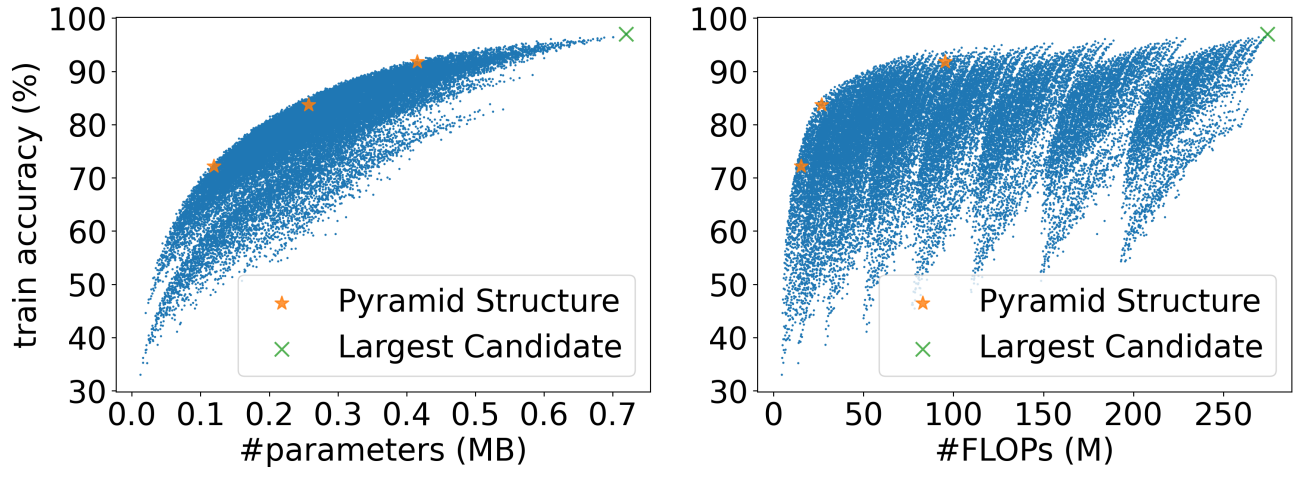


- 基于官方提供基线构建了One-shot 超网，其训练策略采用了Single Path One Shot [2] 中Uniform Sampling方式，配合额外的教师网络进行知识蒸馏，该方案得到的排序一致性的皮尔逊系数(Pearson Correlation Coefficient)为72.49.

- 采用BigNAS [3] /AutoSlim [5] 中Sandwich rule采样策略并训练了35个epoch的训练后取得了74.86的皮尔逊系数。

- 为了降低超网内部的信息损耗，采用PReLU [4] 的激活函数进一步加强超网的一致性,并配合针对性优化策略，能够将排序一致性提高至78.20.

- 受CVPR21阿里提出的Zen-NAS [6] 启发，尝试Zen-Score的排序一致性，发现能够取得非常鲁棒的结果，排序一致性能够大幅提升至81.26.

经过以上实验的探索，构建了一个强力的基线(78.20)，并且奠定了使用**先验进行引导**的基本思想，期望在超网优化过程中注入先验引导性信息，从而指导超网整体训练流程。

区别于LandMark Regularization [7] 中使用真实stand alone精度进行引导方法，本方案提出的方法代价更小，无需经过网络的完整训练过程，能够在尽可能降低计算量影响的情况下，完成排序一致性指标的提升，最终达到超越先验指标的结果。


### 2.1 先验引导 


**(1) FLOPs 引导的先验分析**

网络的计算量是metrics类方法很强的baseline，即模型计算量越大精度越高，并且有着计算高效和通用性强的优势。

在AutoSlim和BigNAS中采用的三明治法则中，使用最大网络对中间层以及最小网络进行蒸馏设定其实就隐含应用了Flops信息，以及计算量引导的采样策略。

经过单独测试发现仅FLOPs指标就能达到78.43的皮尔逊系数，加上FLOPs的引导下进行优化的One-shot NAS超网能够提升排序一致性至81.147，配合渐进变化的weight调整策略能够进一步提升至83.26分。（单纯使用超网训练引导，仅能达到78.20的基线水平）

可见，One-shot NAS中训练策略中依然缺乏先验的引导，FLOPs先验(78.43)引导结合超网训练策略本身(78.20)，能够取得超越两者，达到83.26的皮尔逊系数，显著提升了超网的排序一致性。

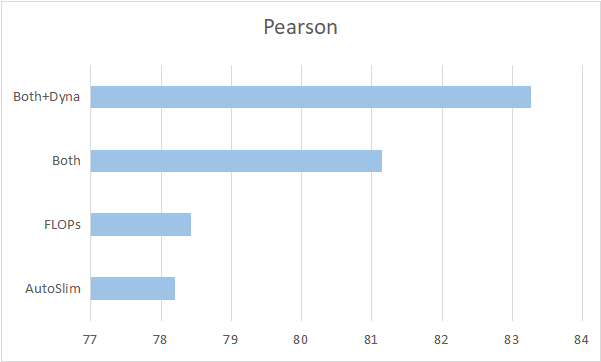

**(2) ZenScore 引导的先验分析**

ZenScore是阿里达摩院ZenNAS[5] 中所采用的指标，如下图所示。

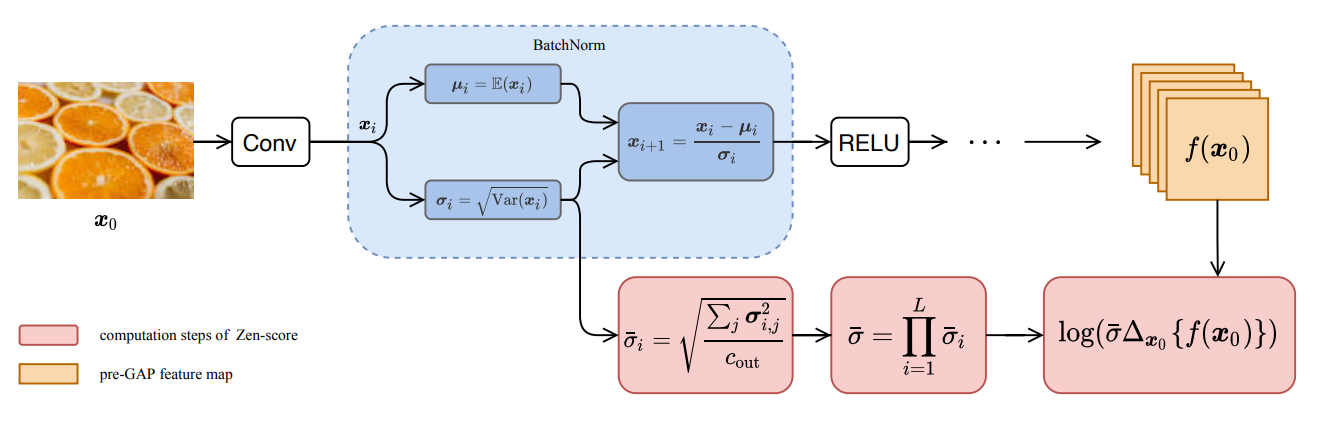

具体通过高斯初始化的网络对于随机输入的鲁棒性以及BatchNorm的统计量结合而成，过程中需要对模型多次前传有一定的开销，但经过测试整体的鲁棒性非常强。如下图所示，本次实验中进行了几个方面的调整：

- Baseline中使用的ZenScore基本还原了官方实现，但是网络结算过程中并没有将ShortCut连接去除。
- Add BS表示使用更大的Batch Size进行更准确的估计，实际结果来看，该指标对BS的鲁棒性很强。
- Del Res表示完全还原了官方的实现方式，将ShortCut链接手动去除。
- Repeat表示使用更多次数的估计，得到更加准确和稳定的结果，虽然有一定提升，但是带来了成倍的计算代价。

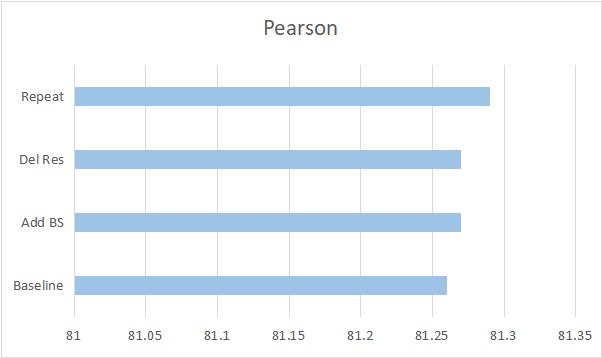

在以上实验基础上(ZenScore指标为81.27)，使用ZenScore引导超网的训练过程，能够取得的分数为83.0的皮尔逊系数。类似于FLOPs，ZenScore引导的超网也能够达到超越基线以及ZenScore本身的结果，具体对比如下图所示：

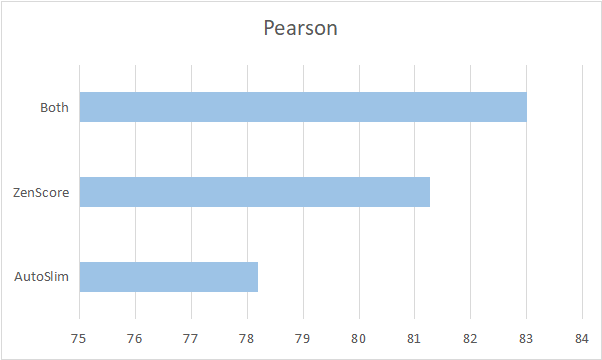


### 2.2 Rank Loss 

这部分介绍具体的结合先验进行引导的方式。具体来说，采用了Pairwise Rank Loss来作为正则项约束SuperNet的优化过程。假定架构 $arch_i$的性能是优于架构$arch_j$的性能，那么在以上排序约束下，理论上满足以下关系：

$$
\mathcal{L}_{\mathcal{A}}\left(x, \theta_{a_{i}}^{*}\right) \leq \mathcal{L}_{\mathcal{A}}\left(x, \theta_{a_{j}}^{*}\right) \Rightarrow \mathcal{L}\left(x, \theta_{a_{i}}^{s}\right) \leq \mathcal{L}\left(x, \theta_{a_{j}}^{s}\right)
$$

其中$\mathcal{L}_{\mathcal{A}}$表示Stand alone训练对应的真实精度, $\mathcal{L}$表示超网中的对应的损失函数排序。那么架构 $arch_i$和架构$arch_j$计算的损失函数为：

$$
\mathcal{R}_{(i,j)}\left(\theta^{s}\right)=\max \left(0, \mathcal{L}\left(x, \theta_{a_{i}}^{s}\right)-\mathcal{L}\left(x, \theta_{a_{j}}^{s}\right)\right)
$$


那么直观地进行解释，以FLOPs为例，当前有两个架构a和b，如果$FLOPS_a < FLOPS_b$, 那么很大程度上意味着 $Loss_a > Loss_b$, 那么 $Loss_a - Lossb_b > 0$ 是正常的，而相反 $Loss_b - Loss_a > 0$会被约束，施加正则项，最简单的方法是借助ReLU进行实现，即：

$$
\mathcal{R}_{(a,b)} = ReLU(Loss_b-Loss_a) = Max(Loss_b-Loss_a, 0)
$$


具体伪代码为：


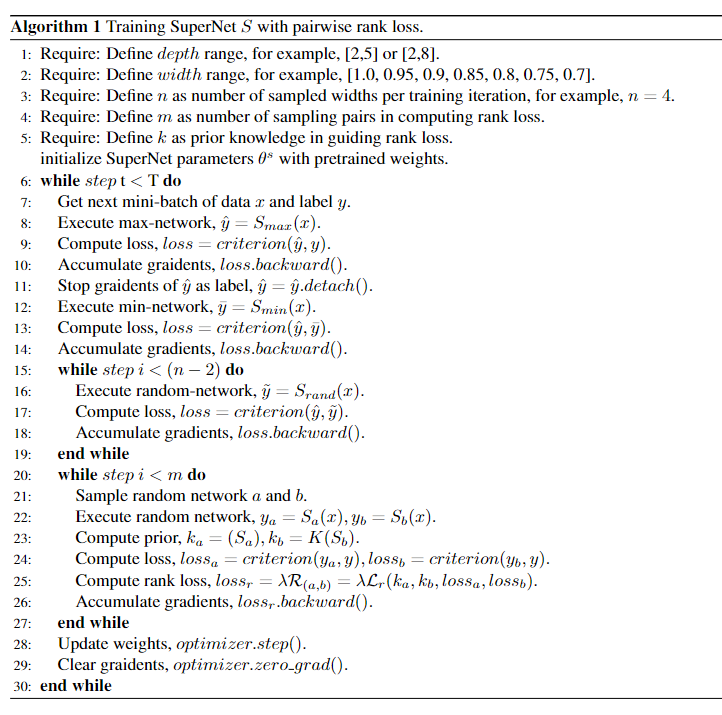


本方案提供了两种引导项，第一组方案是Flops引导的Rank Loss策略；第二组方案是采用ZenScore引导的Rank Loss策略。

Rank Loss的系数$\lambda$是一个比较重要的参数，在训练初期，整体的排序性比较差，如果施加比较大的参数进行惩罚会导致影响模型的正常收敛的问题。因此初期应该存在类似warmup的阶段，我们设计了三种策略，经过尝试发现第三种效果最好。


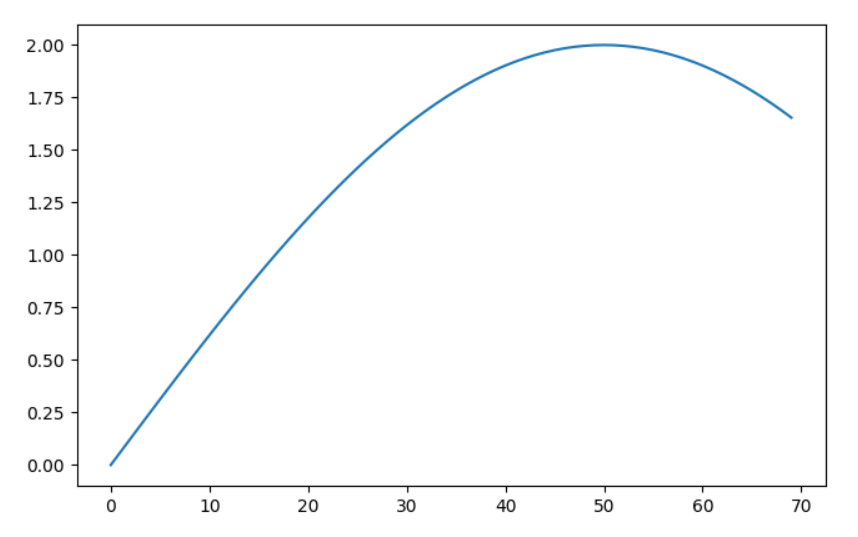

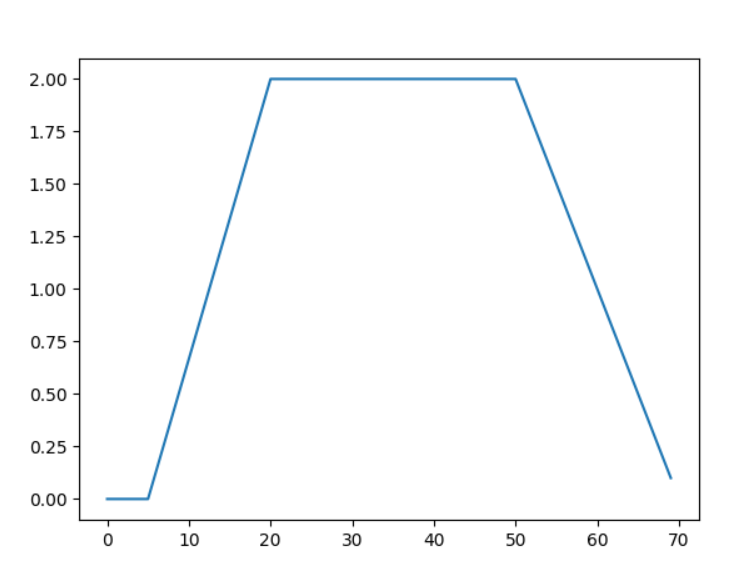

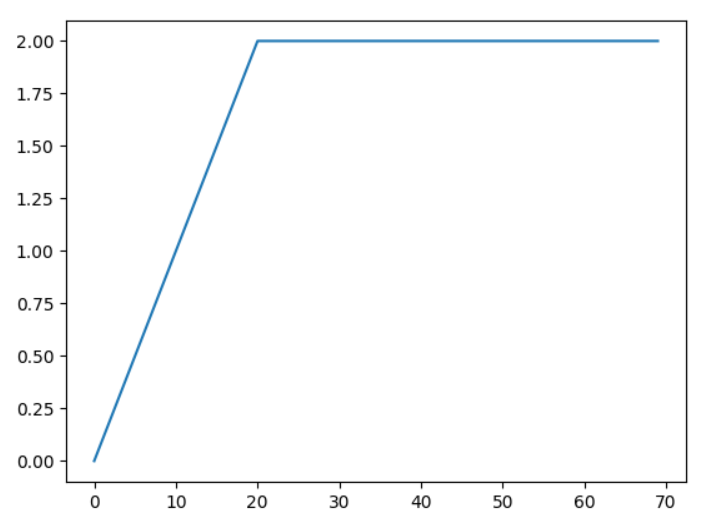



## 三、超网训练策略 

在One-shot NAS中，超网训练时不合理的采样策略会严重影响超网络排序的一致性。具体来说分为两类：

（1）超网中存在某些候选网络需要更高的采样概率才能在共享权重的情况下与Stand-alone的训练情况相匹配，比如BigNAS/AutoSlim中每次迭代都会采用最大的网络进行更新，经过验证，该步骤起到了非常核心的影响。

（2）由于权重共享带来的耦合度高的问题，某个子网更新过程中权重的变化会影响到与其权重共享部分的其他子网络，子网之间可能存在梯度上的冲突。因此采样策略不仅决定了各个架构的训练频率，还影响了权重的优化顺序。

此外，超网由于权重耦合的特殊性，与训练普通固定网络之间存在显著的差异，因此经过参考最新的一些方案，如BigNAS [3], Bag of Tricks for Neural Architecture Search [8], NASVIT [9], Improve Ranking [10] 等，并结合本次赛题实际，我们进行了针对性的设置。



### 3.1 采样策略对比

采样策略对One-shot NAS来说至关重要，本次比赛过程中主要实现了几种主流的采样策略，考虑到赛题是优化Once for all类型的超网（深度可变、宽度可变），因此主要评估了均匀采样一类方法，具体来说包括：

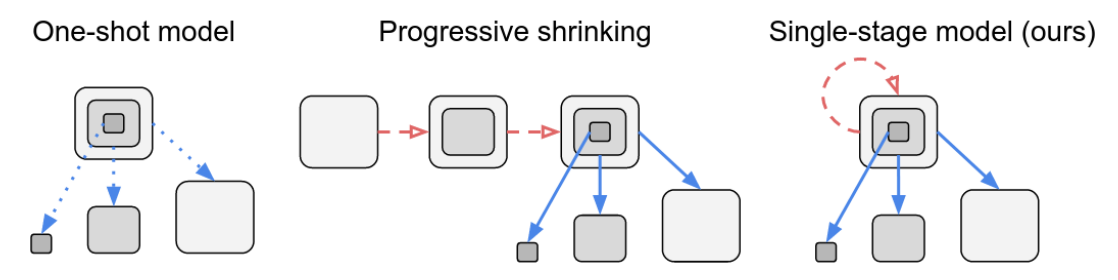

- Uniform Sampling (SPOS [2]) ：采样中会均匀从每层中采样任意操作项；
- Progressive Shrinking (OFA [11])：在训练过程中按照一定先验顺序训练不同的操作项。
- Sandwich Rule (Autoslim [5]/ BigNAS [3])：三明治法则. 每次采样最大最小和随机的中间计算量的模型，并且通过最大模型蒸馏中间模型和小模型。
- Fairnas Rule (FairNAS [12])：同时对每层进行不放回地采样N个路径，以求公平性训练每个操作项目，实现过程中与Sandwich Rule相结合，即随机的中间计算量模型是通过Fairnas rule采样得到的。


具体性能对比如下表：

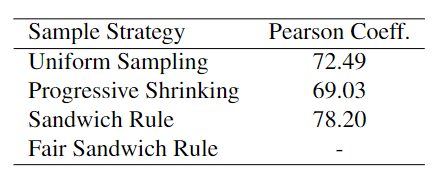

（1）Uniform Sampling策略是所有方法的基准，均匀采样的方法能够一定程度上做到无偏采样，Baseline的皮尔逊系数为72.49。

（2）作为One-Stage NAS中的重要代表，我们也实现了多阶段的Progressive Shrinking的方法，先优化深度Task，分为3个阶段逐步由深层至浅层进行优化；然后优化expansion ratio Task，分为6个阶段，由宽至窄进行优化。由于整个过程中需要调参的内容比较多，经过实验，我们总结出以下经验：

- 在优化每个Task的第一个阶段，需要设置更多的Epoch个数，这样有助于收敛。
- 两个Task中间交接段，需要将Warmup设置为0，这样训练更加平稳。（PS：有点违背直觉，但是实验如此）

并且可以明显看出经过Progressive Shrinking策略引导的超网的精度会更高，甚至能够达到70%左右的准确率(作为对比，Sandwich Rule通常训练过程中只能达到40-60%的准确率。)

（3）Sandwich Rule 是Slimmable Network三部曲中非常重要的策略，在往届比赛中，该方案出现频率很高，并且经过我们的实验证实，该采样策略确实能够显著提升超网的排序一致性(78.20对比72.49).

（4）FairNAS Sandwich Rule 是在验证了Sandwich Rule有效性的基础上，将其随机采样的中间网络替换为FairNAS中的采样法则。但是实验证明，该方案很难收敛。为此，我们设计了进一步实验，即增加Sandwich Rule中间层网络个数。结果发现，在增加采样个数之后，收敛效果出现明显下降，同时排序一致性也受到一定的影响。因此可以一定程度上解释FairNAS Sandwich Rule不收敛的原因。在本次实验中，FairNAS采样个数为7个，远远超出Sandwich Rule中设置的N=2的值，因此梯度主要受到FairNAS影响，并且会与最大网络的更新存在冲突，因此难以收敛。


### 3.2 激活函数 

在 [10] 中提到激活函数的平滑程度会对排序一致性带来一定的影响，原始的ReLU激活对通道数较小的网络的评判是有害的，会导致很多有效信息被滤除。在本次实验中，探索了激活函数对超网排序一致性的影响。并且 [10] 中未提及激活函数位置的影响，在我们的实验中，发现激活函数的位置影响非常大，错误的Setting甚至会导致超网无法收敛。

如下图所示，是一个典型的Residual Block，其中采用了两个ReLU激活函数，第一个ReLU置于两个卷积之间，我们称为Inner activation;第二个ReLU放置于第二个卷积之后，我们称为Outer activation。实验证明，当使用更加平滑的激活函数，如PReLU, Swish, Mish，SELU等，替换掉ReLU，若选择将两者都进行替换，会导致网络无法收敛的情况发生（其他参数设置均无变化）。当且仅当将Outer activation进行替换，且inner activation仍保持ReLU的情况下，超网才能收敛。

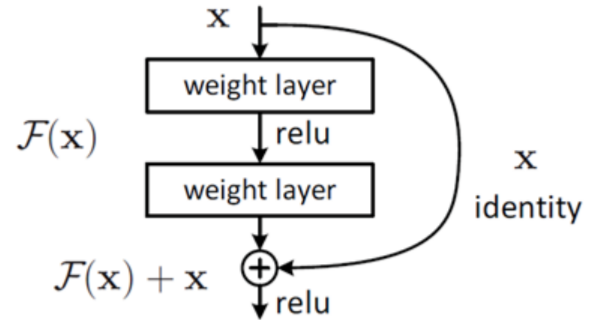


下表展示了各个激活函数对排序一致性带来的影响，实验证明，更加平滑的激活函数对排序一致性是有提升的。其中PReLU形式简单，计算比较简便，同时带来的计算代价更少，因此被选中作为第一组方案的激活函数。而Mish计算相对复杂，但是精度更高，被选为第二组方案的激活函数。

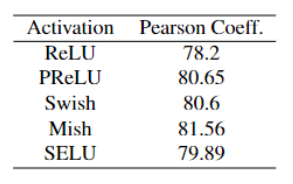


### 3.3 优化策略 

实验中采用的参数设置有：

```
learning rate = 0.001
weight decay = 0. 
momentum = 0.9 
batch size = 256
max epoch = 70
loss = CrossEntropy Loss + Inplace Distillation
optimizer = SGD with Momentum 
warmup 5 epoch
scheduler = CosineAnnealingDecay 
```


One-shot超网优化设置方面我们参考了BigNAS [3], Bag of Tricks for Neural Architecture Search [8], NASVIT [9], Improve Ranking [10] 等，进行了以下设置：

- 尽可能减少了数据增强的使用，仅使用最原始的数据增强策略，不新增CutMix，Cutout等。
- 尽可能减少正则化项的使用，比如Weight decay设置为0，不使用DropOut，DropPath等策略（经实验验证，DropPath会带来约2个点的降低，drop rate=0.1）。



## 四、其他尝试方案


我们也尝试了很多其他方法，并不Work，这里进行分享：

- AlphaNet Loss Fucntion： 这个方法作为NASVIT和AlphaNet中使用的蒸馏策略，理论上比较完整，但是实践来看不论是PyTorch还是Paddle的实现过程中都会遇到梯度下溢出的问题，导致性能直接Drop为0，目前还没有特别好的解决方案。
- Spherical KD：改进蒸馏策略，最终取得了77.05的排序一致性，未达到预期。
- 对齐训练和验证的数据增强方法：影响不大，并且有一定Drop，排序一致性为80.93.
- Longer Epoch：虽然很多论文中显示更长的训练时间有助于排序一致性提升，但是我们的实验表明并非如此。
- BN矫正，Large Batch矫正，Switchable BN等由于框架本身的原因或者其他愿意未能work。
- 降低耦合策略：MLP解耦80.15，SE解耦79.9，BNSE解耦79.1,这种解耦方法性能较差。
- 尝试了最新的蒸馏策略DKD：排序一致性为75，效果较差。

整个过程中，我们还有非常多的想法因为时间和算力所限，未能实现，如果对一些想法感兴趣，欢迎联系我，联系方式放在文末, 欢迎进行学术交流。

最后我们总结一下我们方案中关键的策略以及对应的一致性共享如下表：

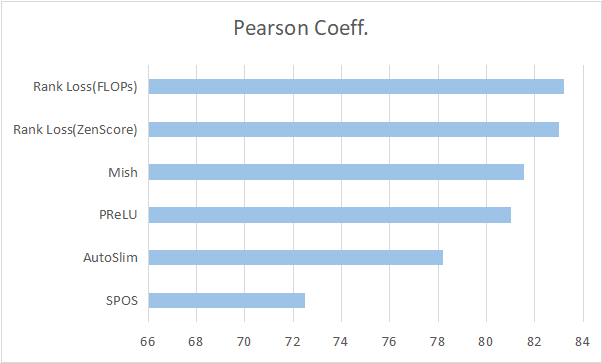


未来工作中我们也会不断探索更多的超网一致性提升的策略，将更多的NAS研究和应用insight共享给社区。



## 五、参考文献


[1] Dong, Xuanyi et al. “NATS-Bench: Benchmarking NAS algorithms for Architecture Topology and Size.” IEEE transactions on pattern analysis and machine intelligence PP (2021): n. pag.

[2] Guo, Zichao et al. “Single Path One-Shot Neural Architecture Search with Uniform Sampling.” ECCV (2020).

[3] Yu, Jiahui et al. “BigNAS: Scaling Up Neural Architecture Search with Big Single-Stage Models.” ECCV (2020).

[4] He, Kaiming et al. “Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.” 2015 IEEE International Conference on Computer Vision (ICCV) (2015): 1026-1034.

[5] Yu, Jiahui and Thomas Huang. “AutoSlim: Towards One-Shot Architecture Search for Channel Numbers.” arXiv: Computer Vision and Pattern Recognition (2019): n. pag.

[6] Lin, Ming et al. “Zen-NAS: A Zero-Shot NAS for High-Performance Deep Image Recognition.” ArXiv abs/2102.01063 (2021): n. pag.

[7] Yu, Kaicheng et al. “Landmark Regularization: Ranking Guided Super-Net Training in Neural Architecture Search.” 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) (2021): 13718-13727.

[8] Elsken, Thomas et al. “Bag of Tricks for Neural Architecture Search.” ArXiv abs/2107.03719 (2021): n. pag.

[9] Gong, Chengyue et al. “NASVIT: NEURAL ARCHITECTURE SEARCH FOR EFFICIENT VISION TRANSFORMERS WITH GRADIENT CONFLICT - AWARE SUPERNET TRAINING.” (2022).

[10] Yang, Ziwei et al. “Improving Ranking Correlation of Supernet with Candidates Enhancement and Progressive Training.” ArXiv abs/2108.05866 (2021): n. pag.

[11] Cai, Han et al. “Once for All: Train One Network and Specialize it for Efficient Deployment.” ArXiv abs/1908.09791 (2020): n. pag.

[12] Chu, Xiangxiang et al. “FairNAS: Rethinking Evaluation Fairness of Weight Sharing Neural Architecture Search.” 2021 IEEE/CVF International Conference on Computer Vision (ICCV) (2021): 12219-12228.

========================================这是一个分割线==============================================

以下内容是代码复现部分


## Prior-Guided Neural Architecture Search 

Competition Homepage: [2022 CVPR Track1: SuperNet Track](https://aistudio.baidu.com/aistudio/competition/detail/149/0/introduction)


Table of Content

- Environment Setup
- SuperNet Training
- SuperNet Evaluation 

### 1. Environment Setup

Checkpoint Download Link: 

```
链接：https://pan.baidu.com/s/1bXcJmFk-BGYca0wdQw9Jkg 
提取码：bxvg
```


1.1 Env Requirements

The memory of GPU should not be smaller than **32GB**. V100 with 32GB is recommended.


```
paddlepaddle-gpu==2.2.2
fire
matplotlib
visualdl 
```

You can run commands:

```bash
pip install -r requirements.txt 
```

1.2 Data Prepare 

You can download imagenet-mini [from kaggle](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000). 

ImageNet-mini is a toy dataset compared with imagenet-1k, which has 1000 classes and is only 4.24GB.

For quick iteration, we adopted imagenet-mini as a dataset for training and evaluation. If you have enough computation resources, you can try imagine-1k directly.

In PP AI Studio, [imagenet-mini datasets](https://aistudio.baidu.com/aistudio/datasetdetail/89857) have been offered to us. 


1.3 Arch Json Prepare 

[Here](https://aistudio.baidu.com/aistudio/datasetdetail/134077) you can get the 4,5000 architectures for test. Download CVPR_2022_NAS_Track1_test.json and put it to `checkpoints/CVPR_2022_NAS_Track1_test.json` 


In [1]:
# 查看当前挂载的数据集目录, 解压数据集
!ls /home/aistudio/data
!unzip -n /home/aistudio/data/data147963/imagenet-mini.zip -d /home/aistudio/data/data147963/ > /dev/null
# !tar -xvf /home/aistudio/data/data89857/ILSVRC2012mini.tar
# DATASET_PATH="/home/aistudio/data/data89857/ILSVRC2012mini"
DATASET_PATH="/home/aistudio/data/data147963/imagenet-mini"
print("Done")

data147963
Done


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 解压代码
!unzip -n CVPR2022-NAS-competition-Track-1-3th-solution.zip > /dev/null
!cd CVPR2022-NAS-competition-Track-1-3th-solution/

In [4]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!cd CVPR2022-NAS-competition-Track-1-3th-solution/
!ls
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries
!pip install -r CVPR2022-NAS-competition-Track-1-3th-solution/requirements.txt

CVPR2022-NAS-competition-Track-1-3th-solution	   external-libraries
CVPR2022-NAS-competition-Track-1-3th-solution.zip  main.ipynb
data						   work
mkdir: 无法创建目录"/home/aistudio/external-libraries": 文件已存在
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 15.0 MB/s eta 0:00:00
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=924a919c915fb859d1191ca0271b8ad31f434560dcb0b5f05ffc6ce61c4b13a0
  Stored in directory: /home/aistudio/.cache/pip/wheels/65/a5/a7/3ca725beade9676a2e72fe779d09efc89931fba0d90966d8ec
Successfully built fire
You should consider upgrading via the '/opt/conda/env

In [5]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')
sys.path.append('/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution')

## 2. SuperNet Training

In this part, we will introduce the overall flow of training.

(1) Import necessary modules.

In [6]:
import os

import paddle
import paddle.nn as nn
from paddle.nn import CrossEntropyLoss
from paddle.vision.transforms import (
    RandomHorizontalFlip, RandomResizedCrop, SaturationTransform, 
    Compose, Resize, HueTransform, BrightnessTransform, ContrastTransform, 
    RandomCrop, Normalize, RandomRotation, CenterCrop)
from paddle.io import DataLoader
from paddle.optimizer.lr import CosineAnnealingDecay, MultiStepDecay, LinearWarmup

from hnas.utils.callbacks import LRSchedulerM, MyModelCheckpoint
from hnas.utils.transforms import ToArray
from hnas.dataset.random_size_crop import MyRandomResizedCrop
from paddle.vision.datasets import DatasetFolder

from paddleslim.nas.ofa.convert_super import Convert, supernet
from paddleslim.nas.ofa import RunConfig, DistillConfig, ResOFA
from paddleslim.nas.ofa.utils import utils

import paddle.distributed as dist
from hnas.utils.yacs import CfgNode
from hnas.models.builder import build_classifier
from hnas.utils.hapi_wrapper import Trainer

[05-22 11:14:31 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:1027: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'floating': np.float,
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of

(2) Set the loss function and accuracy tools.

We offer three ways to compute loss:

- Normal CrossEntropy Loss for teacher network.  
- Inplace Distillation for student network.
- Knowledge Distillation for student network.

In [7]:
def _loss_forward(self, input, tea_input=None, label=None):
    if tea_input is not None and label is not None:
        # knoledge distillation = cross entropy + inplace distillation
        ce = paddle.nn.functional.cross_entropy(
            input,
            label,
            weight=self.weight,
            ignore_index=self.ignore_index,
            reduction=self.reduction,
            soft_label=self.soft_label,
            axis=self.axis,
            name=self.name)

        kd = paddle.nn.functional.cross_entropy(
            input,
            paddle.nn.functional.softmax(tea_input),
            weight=self.weight,
            ignore_index=self.ignore_index,
            reduction=self.reduction,
            soft_label=True,
            axis=self.axis)
        return ce, kd
    elif tea_input is not None and label is None:
        # inplace distillation
        kd = paddle.nn.functional.cross_entropy(
            input,
            paddle.nn.functional.softmax(tea_input),
            weight=self.weight,
            ignore_index=self.ignore_index,
            reduction=self.reduction,
            soft_label=True,
            axis=self.axis)
        return kd 
    elif label is not None:
        # normal cross entropy 
        ce = paddle.nn.functional.cross_entropy(
            input,
            label,
            weight=self.weight,
            ignore_index=self.ignore_index,
            reduction=self.reduction,
            soft_label=False,
            axis=self.axis,
            name=self.name)
        return ce
    else:
        raise "Not Implemented Loss."

CrossEntropyLoss.forward = _loss_forward

def _compute(self, pred, tea_pred, label=None, *args):
    if label is None:
        label = tea_pred
    pred = paddle.argsort(pred, descending=True)
    pred = paddle.slice(
        pred, axes=[len(pred.shape) - 1], starts=[0], ends=[self.maxk])
    if (len(label.shape) == 1) or \
        (len(label.shape) == 2 and label.shape[-1] == 1):
        label = paddle.reshape(label, (-1, 1))
    elif label.shape[-1] != 1:
        label = paddle.argmax(label, axis=-1, keepdim=True)
    correct = pred == label
    return paddle.cast(correct, dtype='float32')

paddle.metric.Accuracy.compute = _compute

(3) Hyperparameter Settings.

In [8]:
train_cfg = {
    "backbone" :"resnet48_prelu",
    "image_size" :'224',
    "max_epoch" : 70, # for test set 3; full run set 70 or more
    "lr" :0.001,
    "weight_decay" :0.,
    "momentum" :0.9,
    "batch_size" :256,
    "dyna_batch_size" :4,
    "warmup" :2,
    "phase" :None,
    "resume" :None,
    "pretrained" :None, # "/home/aistudio/checkpoints/resnet48.pdparams", # this file is too big to upload.
    "image_dir" :DATASET_PATH,
    "save_dir" :"/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/res48-rank-loss",
    "save_freq" :20,
    "log_freq" :100,
    "visualdl_dir" :"/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/visualdl_log/autoslim3",
}

In [9]:
def run(
    backbone='resnet48',
    image_size='224',
    max_epoch=120,
    lr=0.0025,
    weight_decay=0.,
    momentum=0.9,
    batch_size=80,
    dyna_batch_size=4,
    warmup=2,
    phase=None,
    resume=None,
    pretrained='checkpoints/resnet48.pdparams',
    image_dir='/root/paddlejob/workspace/env_run/data/ILSVRC2012/',
    save_dir='checkpoints/res48-depth',
    save_freq=20,
    log_freq=100,
    visualdl_dir="./visualdl_log/autoslim3",
    **kwargs
    ):
    run_config = locals()
    run_config.update(run_config["kwargs"])
    del run_config["kwargs"]
    config = CfgNode(run_config)
    config.image_size_list = [int(x) for x in config.image_size.split(',')]

    nprocs = len(paddle.get_cuda_rng_state())
    gpu_str = []
    for x in range(nprocs):
        gpu_str.append(str(x))
    gpu_str = ','.join(gpu_str)
    print(f'gpu num: {nprocs}')
    # dist.spawn(main, args=(config,), nprocs=nprocs, gpus=gpu_str)
    main(config)


def main(cfg):
    paddle.set_device('gpu:{}'.format(dist.ParallelEnv().device_id))
    if dist.get_rank() == 0:
        print(cfg)
    IMAGE_MEAN = (0.485,0.456,0.406)
    IMAGE_STD = (0.229,0.224,0.225)

    cfg.lr = cfg.lr * cfg.batch_size * dist.get_world_size() / 256
    warmup_step = int(1281024 / (cfg.batch_size * dist.get_world_size())) * cfg.warmup

    # data augmentation 
    transforms = Compose([
        MyRandomResizedCrop(cfg.image_size_list),
        RandomHorizontalFlip(),
        ToArray(),
        Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
    train_set = DatasetFolder(os.path.join(cfg.image_dir, 'train'), transform=transforms)
    callbacks = [LRSchedulerM(), 
                 MyModelCheckpoint(cfg.save_freq, cfg.save_dir, cfg.resume, cfg.phase),
                 paddle.callbacks.VisualDL(log_dir=cfg.visualdl_dir)]

    # build resnet48 and teacher net
    net = build_classifier(cfg.backbone, pretrained=cfg.pretrained, reorder=True)
    tnet = build_classifier(cfg.backbone, pretrained=cfg.pretrained, reorder=False)
    origin_weights = {}
    for name, param in net.named_parameters():
        origin_weights[name] = param
    
    # convert resnet48 to supernet 
    sp_model = Convert(supernet(expand_ratio=[1.0])).convert(net)  # net转换成supernet
    utils.set_state_dict(sp_model, origin_weights)  # 重新对supernet加载数据
    del origin_weights

    # set candidate config 
    cand_cfg = {
            'i': [224],  # image size
            'd': [(2, 5), (2, 5), (2, 8), (2, 5)],  # depth
            'k': [3],  # kernel size
            'c': [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7] # channel ratio
    }

    default_distill_config = {
        'lambda_distill': 0.5,
        'teacher_model': tnet,
        'mapping_layers': None,
        'teacher_model_path': None,
        'distill_fn': None,
        'mapping_op': 'conv2d'
    }

    ofa_net = ResOFA(sp_model,
                     distill_config=DistillConfig(**default_distill_config), 
                     candidate_config=cand_cfg,
                     block_conv_num=2)

    # ofa_net.set_task(['depth', 'expand_ratio'])
    ofa_net.set_task('expand_ratio')

    run_config = {'dynamic_batch_size': cfg.dyna_batch_size}
    model = Trainer(ofa_net, cfg=run_config)

    # calculate loss by ce 
    model.prepare(
        paddle.optimizer.Momentum(
            learning_rate=LinearWarmup( # delete cfg.lr * 0.05 
                CosineAnnealingDecay(cfg.lr, cfg.max_epoch), warmup_step, 0., cfg.lr),
            momentum=cfg.momentum,
            parameters=model.parameters(),
            weight_decay=cfg.weight_decay),
        CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1,5)))
        
    model.fit(
        train_set,
        None,
        epochs=cfg.max_epoch,
        batch_size=cfg.batch_size,
        save_dir=cfg.save_dir,
        save_freq=cfg.save_freq,
        log_freq=cfg.log_freq,
        shuffle=True,
        num_workers=1,
        verbose=2, 
        drop_last=True,
        callbacks=callbacks,
    )

(5) Start to run.

We call `paddle.flops` to calculate the flops of corresponding architecture. However, there will be lots of intermediate information such as:

```
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
Total Flops: 3501143072     Total Params: 16545128
```

You can delete them by modify `envs/pp/lib/python3.7/site-packages/paddle/hapi/dynamic_flops.py` to avoid the useless logs.

In [ ]:

run(backbone=train_cfg["backbone"], 
    image_size=train_cfg["image_size"],
    max_epoch=train_cfg["max_epoch"],
    lr=train_cfg["lr"],
    weight_decay=train_cfg["weight_decay"],
    momentum=train_cfg["momentum"],
    batch_size=train_cfg["batch_size"],
    dyna_batch_size=train_cfg["dyna_batch_size"],
    warmup=train_cfg["warmup"],
    pretrained=train_cfg["pretrained"],
    image_dir=train_cfg["image_dir"],
    save_dir=train_cfg["save_dir"],
    visualdl_dir=train_cfg["visualdl_dir"],
    )

gpu num: 1
backbone: resnet48_prelu
batch_size: 256
dyna_batch_size: 4
image_dir: /home/aistudio/data/data147963/imagenet-mini
image_size: 224
image_size_list: [224]
log_freq: 100
lr: 0.001
max_epoch: 70
momentum: 0.9
phase: None
pretrained: None
resume: None
save_dir: /home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/res48-rank-loss
save_freq: 20
visualdl_dir: /home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/visualdl_log/autoslim3
warmup: 2
weight_decay: 0.0


W0522 11:14:32.922945   183 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0522 11:14:32.928969   183 device_context.cc:465] device: 0, cuDNN Version: 7.6.


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/70


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
Total Flops: 2566305280     Total Params: 17992648


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
Total Flops: 3501143072     Total Params: 16545128
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
Total Flops: 1989961680     Total Params: 9804312
<

The previous section did not cover the core implementation. In the next section we will describe how `RANK LOSS` is built.

Rank Loss Function: 

```python
import paddle.nn as nn
import paddle.nn.functional as F

class PairwiseRankLoss(nn.Layer):
    """pairwise ranking loss for rank consistency 

    Args:
        prior1 (float | int): the prior value of arch1 
        prior2 (float | int): the prior value of arch2 
        loss1: the batch loss of arch1 
        loss2: the batch loss of arch2 
    """

    def forward(self, prior1, prior2, loss1, loss2, coeff=1.):
        return coeff * F.relu(loss2-loss1.detach()) if prior1 < prior2 else coeff * F.relu(loss1.detach()-loss2)
```


Integrate Pairwise `Rank Loss` into the `Sandwich Rule`. For example, take flops as prior.

```python
def train_batch_sandwich_with_rank(self, inputs, labels=None, **kwargs):
    assert self.model._optimizer, "model not ready, please call `model.prepare()` first"
    self.model.network.model.train() # set network to training mode.
    self.mode = 'train'

    inputs = to_list(inputs)
    self._input_info = _update_input_info(inputs)
    labels = to_variable(labels).squeeze(0)
    epoch = kwargs.get('epoch', None)
    self.epoch = epoch
    nBatch = kwargs.get('nBatch', None)
    step = kwargs.get('step', None)

    subnet_seed = int('%d%.1d' % (epoch * nBatch + step, step)) # set seed 
    np.random.seed(subnet_seed)

    ######### Sandwich Rule ##############

    # sample largest subnet as teacher network
    largest_config = self.model.network.active_autoslim_subnet(sample_type="largest")
    self.model.network.set_net_config(largest_config)
    if self._nranks > 1:
        teacher_output = self.ddp_model.forward(*[to_variable(x) for x in inputs])
    else:
        teacher_output = self.model.network.forward(*[to_variable(x) for x in inputs])
    # normal forward with CrossEntropy. 
    loss1 = self.model._loss(input=teacher_output[0], tea_input=None, label=labels)
    loss1.backward()

    # sample smallest subnet as student network and perform distill operation
    smallest_config = self.model.network.active_autoslim_subnet(sample_type="smallest")
    self.model.network.set_net_config(smallest_config)
    if self._nranks > 1:
        output = self.ddp_model.forward(*[to_variable(x) for x in inputs])
    else:
        output = self.model.network.forward(*[to_variable(x) for x in inputs])
    # forward with inplace distillation
    loss2 = self.model._loss(input=output[0],tea_input=teacher_output[0], label=None)
    loss2.backward()
    del output 

    # sample random subnets as student net and perform distill operation
    for _ in range(self.dyna_bs-2): 
        random_config1 = self.model.network.active_autoslim_subnet(sample_type="random")
        self.model.network.set_net_config(random_config1)
        if self._nranks > 1:
            output = self.ddp_model.forward(*[to_variable(x) for x in inputs])
        else:
            output = self.model.network.forward(*[to_variable(x) for x in inputs])
        # forward with inplace distillation
        loss = self.model._loss(input=output[0],tea_input=teacher_output[0], label=None)
        loss.backward()
        del output

    # pairwise rank loss 
    for _ in range(self.dyna_bs-2):
        # generate two random arch to compute pairwise rank loss.
        random_config1 = self.model.network.active_autoslim_subnet(sample_type="random")
        self.model.network.set_net_config(random_config1)
        flops1 = get_arch_flops(self.model.network.gen_subnet_code)
        if self._nranks > 1:
            output = self.ddp_model.forward(*[to_variable(x) for x in inputs])
        else:
            output = self.model.network.forward(*[to_variable(x) for x in inputs])
        loss3 = self.model._loss(input=output[0],tea_input=None, label=labels)
        del output

        random_config2 = self.model.network.active_autoslim_subnet(sample_type="random")
        self.model.network.set_net_config(random_config2)
        flops2 = get_arch_flops(self.model.network.gen_subnet_code)
        if self._nranks > 1:
            output = self.ddp_model.forward(*[to_variable(x) for x in inputs])
        else:
            output = self.model.network.forward(*[to_variable(x) for x in inputs])
        loss4 = self.model._loss(input=output[0],tea_input=None, label=labels)
        
        # gradually increase rank loss weights.
        loss5 =  min(2, epoch/10.) * self.pairwise_rankloss(flops1, flops2, loss3, loss4)
        loss5.backward()

    self.model._optimizer.step()
    self.model._optimizer.clear_grad()

    metrics = []
    for metric in self.model._metrics:
        metric_outs = metric.compute(output[0], labels)
        m = metric.update(*[to_numpy(m) for m in to_list(metric_outs)])
        metrics.append(m)

    return ([to_numpy(l) for l in [loss1]], metrics) if len(metrics) > 0 else [to_numpy(l) for l in [loss1]]
```

## 3. SubNet Evaluation


In [ ]:
import os

import paddle
import paddle.distributed as dist
from paddle.nn import CrossEntropyLoss
from paddle.optimizer.lr import CosineAnnealingDecay, LinearWarmup
from paddle.vision.datasets import DatasetFolder
from paddle.vision.transforms import CenterCrop, Compose, Normalize, Resize

from hnas.models.builder import build_classifier
from hnas.utils.callbacks import EvalCheckpoint
from hnas.utils.transforms import ToArray
from hnas.utils.yacs import CfgNode
from paddleslim.nas.ofa import DistillConfig, ResOFA
from paddleslim.nas.ofa.convert_super import Convert, supernet
from paddleslim.nas.ofa.utils import utils

In [ ]:
eval_cfg = {
    "backbone" :"resnet48_prelu",
    "image_size" :'224',
    "max_epoch" :70,
    "lr" :0.001,
    "weight_decay" :0.,
    "momentum" :0.9,
    "batch_size" :256,
    "dyna_batch_size" :4,
    "warmup" :2,
    "phase" :None,
    "resume" : "/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/res48-rank-loss",
    "pretrained" : None, #"checkpoints/resnet48.pdparams", this file is too big to upload.
    "image_dir" : DATASET_PATH,
    "save_dir" :"/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/res48-rank-loss",
    "save_freq" :20,
    "log_freq" :100,
    "json_path" : "/home/aistudio/CVPR2022-NAS-competition-Track-1-3th-solution/checkpoints/CVPR_2022_NAS_Track1_test.json"
}

In [ ]:
def run(
    backbone='resnet48',
    image_size='224',
    max_epoch=120,
    lr=0.0025,
    weight_decay=3e-5,
    momentum=0.9,
    batch_size=80,
    dyna_batch_size=4,
    warmup=2,
    phase=None,
    resume=None,
    pretrained='checkpoints/resnet48.pdparams',
    image_dir='/root/paddlejob/workspace/env_run/data/ILSVRC2012/',
    save_dir='checkpoints/res48-depth',
    save_freq=5,
    log_freq=100,
    json_path=None,
    **kwargs
    ):
    run_config = locals()
    run_config.update(run_config["kwargs"])
    del run_config["kwargs"]
    config = CfgNode(run_config)
    config.image_size_list = [int(x) for x in config.image_size.split(',')]

    nprocs = len(paddle.get_cuda_rng_state())
    gpu_str = []
    for x in range(nprocs):
        gpu_str.append(str(x))
    gpu_str = ','.join(gpu_str)
    print(f'gpu num: {nprocs}')
    # dist.spawn(main, args=(config,), nprocs=nprocs, gpus=gpu_str)
    main(config)


def main(cfg):
    paddle.set_device('gpu:{}'.format(dist.ParallelEnv().device_id))
    if dist.get_rank() == 0:
        print(cfg)
    IMAGE_MEAN = (0.485,0.456,0.406)
    IMAGE_STD = (0.229,0.224,0.225)

    cfg.lr = cfg.lr * cfg.batch_size * dist.get_world_size() / 256
    warmup_step = int(1281024 / (cfg.batch_size * dist.get_world_size())) * cfg.warmup

    val_transforms = Compose([Resize(256), CenterCrop(224), ToArray(), Normalize(IMAGE_MEAN, IMAGE_STD)])
    val_set = DatasetFolder(os.path.join(cfg.image_dir, 'val'), transform=val_transforms)
    # val_set = HDF5DatasetFolder("/data/home/scv6681/run/data/hdf5/imagenetmini_val.h5", transform=val_transforms)

    eval_callbacks = [EvalCheckpoint('{}/final'.format(cfg.save_dir))]

    net = build_classifier(cfg.backbone, pretrained=cfg.pretrained, reorder=True)
    tnet = build_classifier(cfg.backbone, pretrained=cfg.pretrained, reorder=False)
    origin_weights = {}
    for name, param in net.named_parameters():
        origin_weights[name] = param
    
    sp_model = Convert(supernet(expand_ratio=[1.0])).convert(net)  # net转换成supernet
    utils.set_state_dict(sp_model, origin_weights)  # 重新对supernet加载数据
    del origin_weights

    cand_cfg = {
            'i': [224],  # image size
            'd': [(2, 5), (2, 5), (2, 8), (2, 5)],  # depth
            'k': [3],  # kernel size
            'c': [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7] # channel ratio
    }
    ofa_net = ResOFA(sp_model,
                     distill_config=DistillConfig(teacher_model=tnet), 
                     candidate_config=cand_cfg,
                     block_conv_num=2)
    ofa_net.set_task('expand_ratio')

    run_config = {'dynamic_batch_size': cfg.dyna_batch_size}
    model = Trainer(ofa_net, cfg=run_config)
    model.prepare(
        paddle.optimizer.Momentum(
            learning_rate=LinearWarmup(
                CosineAnnealingDecay(cfg.lr, cfg.max_epoch), warmup_step, 0., cfg.lr),
            momentum=cfg.momentum,
            parameters=model.parameters(),
            weight_decay=cfg.weight_decay),
        CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1,5)))

    model.evaluate_whole_test(val_set, batch_size=cfg.batch_size, num_workers=1, callbacks=eval_callbacks, json_path=cfg.json_path)

In [ ]:
run(backbone=eval_cfg["backbone"], 
    image_size=eval_cfg["image_size"],
    max_epoch=eval_cfg["max_epoch"],
    lr=eval_cfg["lr"],
    weight_decay=eval_cfg["weight_decay"],
    momentum=eval_cfg["momentum"],
    batch_size=eval_cfg["batch_size"],
    dyna_batch_size=eval_cfg["dyna_batch_size"],
    warmup=eval_cfg["warmup"],
    pretrained=eval_cfg["pretrained"],
    image_dir=eval_cfg["image_dir"],
    save_dir=eval_cfg["save_dir"],
    json_path=eval_cfg["json_path"],
    )

Github主页：https://github.com/pprp 

Zhihu主页：https://www.zhihu.com/people/peijieDong

CSDN博客：https://blog.csdn.net/DD_PP_JJ

博客园主页：https://www.cnblogs.com/pprp

联系方式：wx: topeijie 